# CS4035 - Cyber Data Analytics
## Lab 2 - Anomaly Detection

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 2 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

Maximum number of words is 1600, which you can count with the code below.

In [111]:
# If this cell does not work try running `pip install nbformat`

# import io
import nbformat

nb = nbformat.read("Lab2.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 737


## Group Number : 1

## Student 1 
### Name : Amar Mesic
### ID : 5106117

## Student 2
### Name : Athanasios Georgoutsos
### ID : 6015883

## Readme 

### Libraries used
You can install everything from requirements.txt, otherwise install packages as you go through the notebook

### contents
This notebook is structured as follows:
- Familiarization task
- LOF task
- PCA task
- ARMA task
- N-gram task
- Comparison task
- Bonus task

In [4]:
# Libraries used in this lab assignment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import signal

# The following code defines the paths of the data files
train_path = 'cda-lab-2-anomaly-detection/train_data.csv'
val_path = 'cda-lab-2-anomaly-detection/val_data.csv'
test_path = 'cda-lab-2-anomaly-detection/test_data.csv'

## 1. Familiarization task – 1 A4

In [5]:
# load data
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

train_data.head()

,Id,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Label
0,0,22/12/2015 4:00:00 PM,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,0
1,1,22/12/2015 4:00:01 PM,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,0
2,2,22/12/2015 4:00:02 PM,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,0
3,3,22/12/2015 4:00:03 PM,2.428338,260.2850,2,2,1,244.3284,8.19008,306.101,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,0
4,4,22/12/2015 4:00:04 PM,2.424815,259.8925,2,2,1,244.4245,8.19008,306.101,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,0


In [6]:
# find out timestamp of first and last measurement
print('First measurement:', train_data['Timestamp'][0])
print('Last measurement:', train_data['Timestamp'][len(train_data)-1])

First measurement:  22/12/2015 4:00:00 PM
Last measurement:  28/12/2015 9:59:59 AM


In [8]:
# find out different columns
print('Columns:', train_data.columns)


Columns: Index(['Id', 'Timestamp', 'FIT101', 'LIT101', 'MV101', 'P101', 'P102',
       'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203',
       'P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302',
       'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401',
       'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502',
       'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501',
       'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603',
       'Label'],
      dtype='object')


In [9]:
# some preprocessing

# keep columns for signals
signals = train_data.columns.drop(['Id', 'Timestamp', 'Label'])
print('Number of signals:', len(signals))

# convert timestamp to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], dayfirst = True)

Number of signals: 51


/var/folders/gn/8cmn0qdj1mx7g0mxnt5q722h0000gp/T/ipykernel_90519/3409347687.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], dayfirst = True)


### 1a. Plot visualizations 

#### Signal Correlation Heatmap

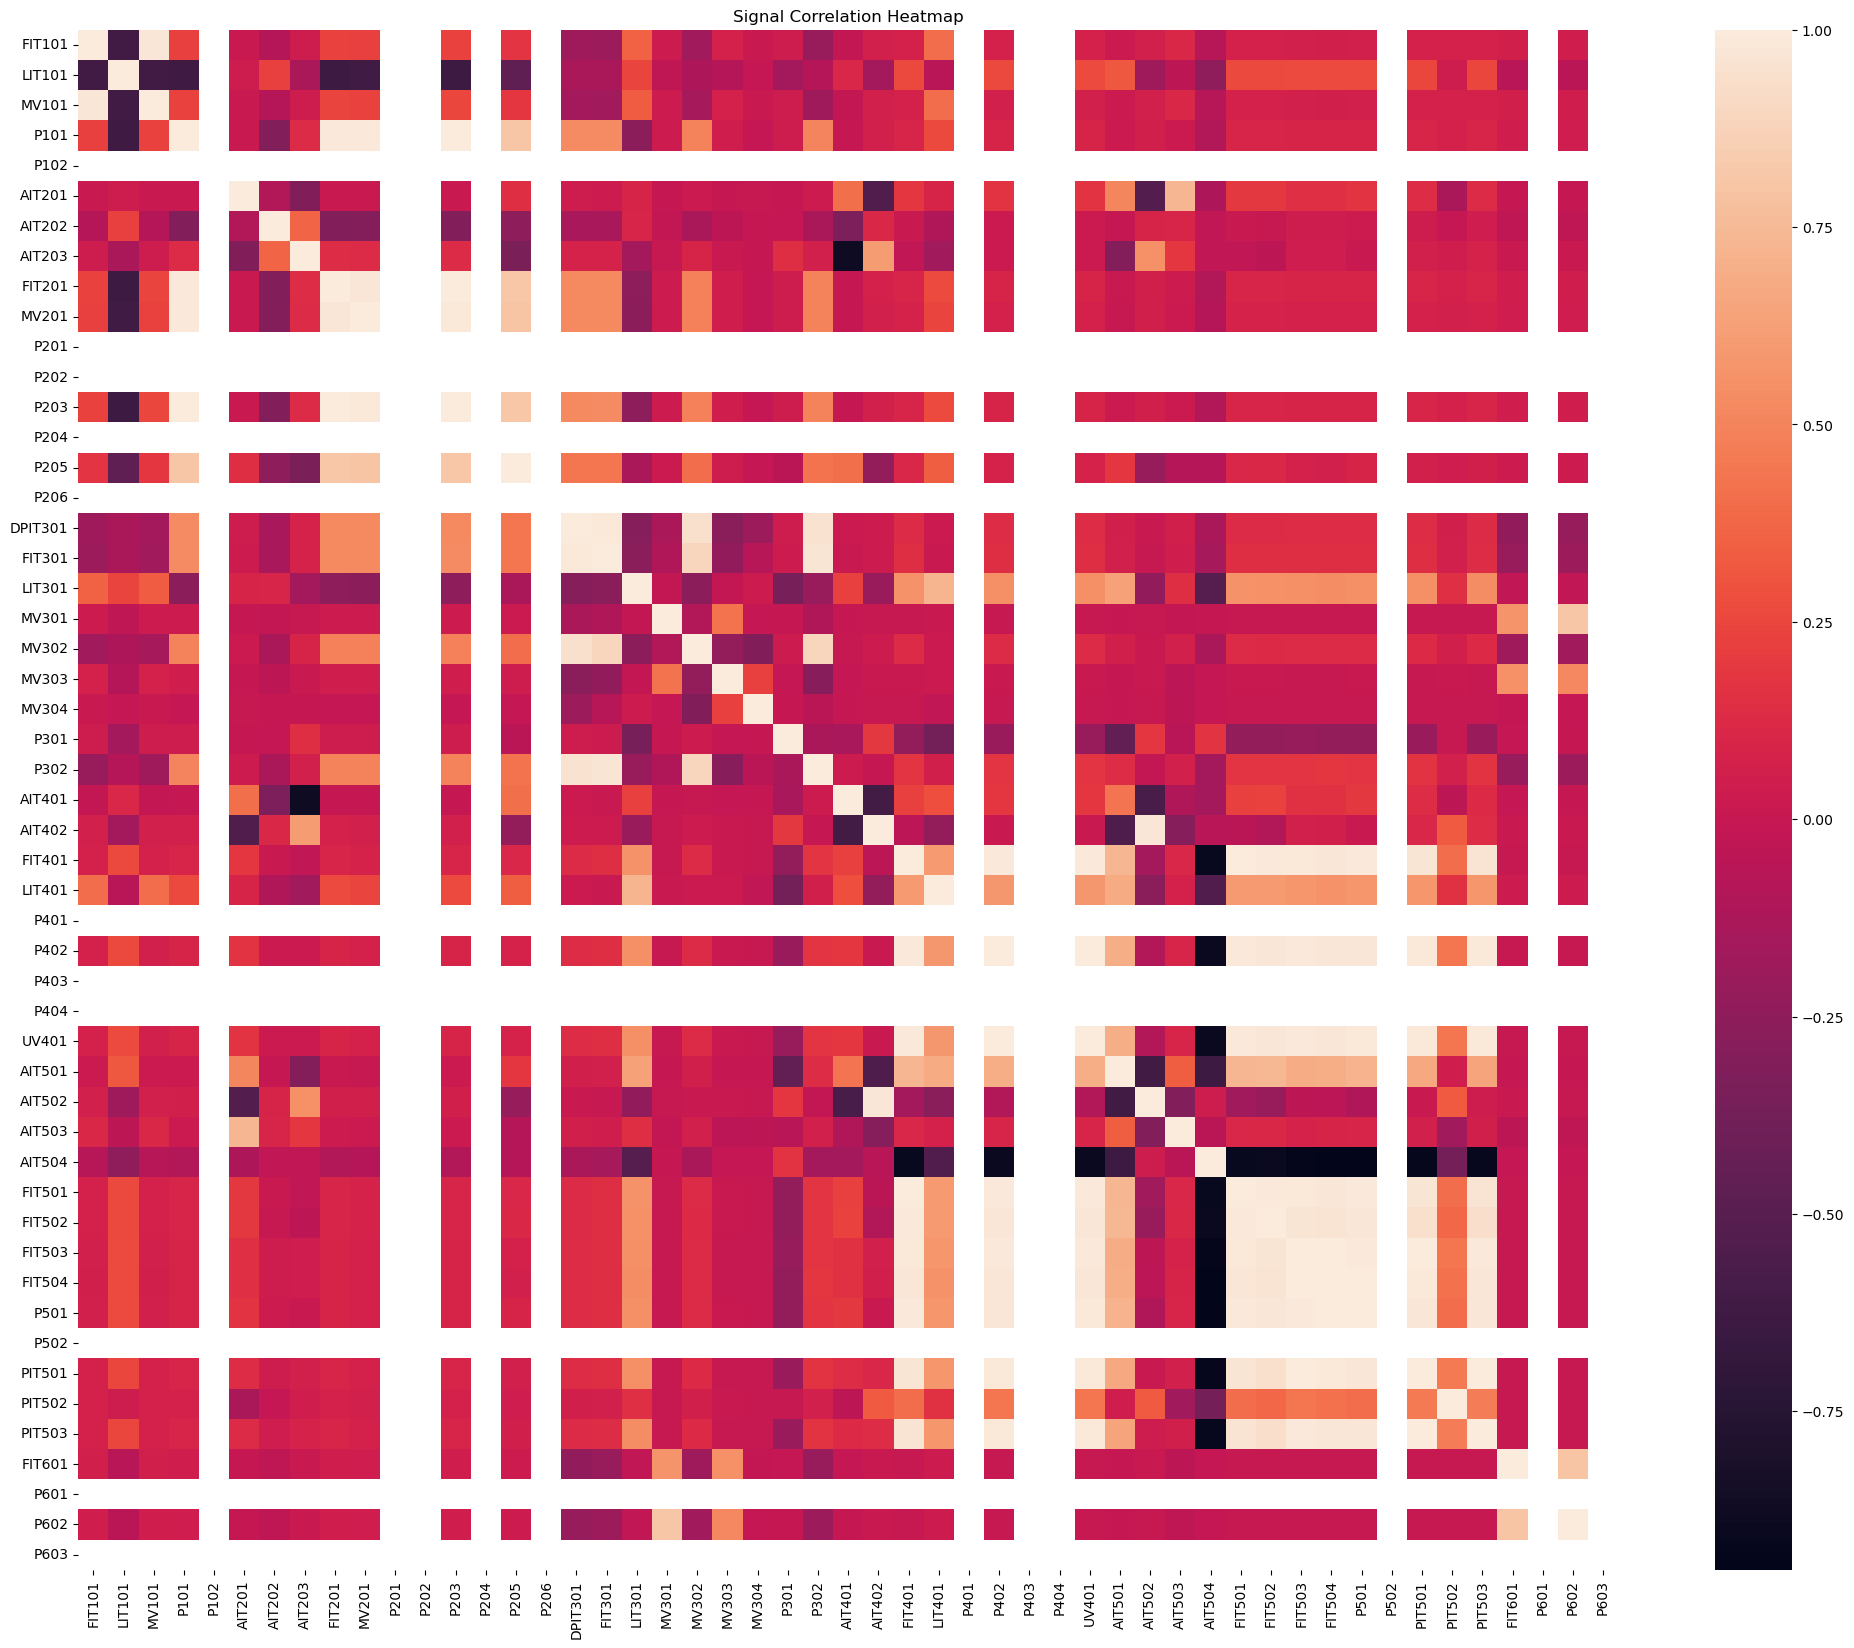

In [10]:
# plot heatmap to detect correlation
f, ax = plt.subplots(figsize =(25, 20))

train_signals = train_data[signals]

sns.heatmap(train_signals.corr(), square=True)
ax.set_title('Signal Correlation Heatmap')

plt.show()

#### Plot values of sensor FIT-101

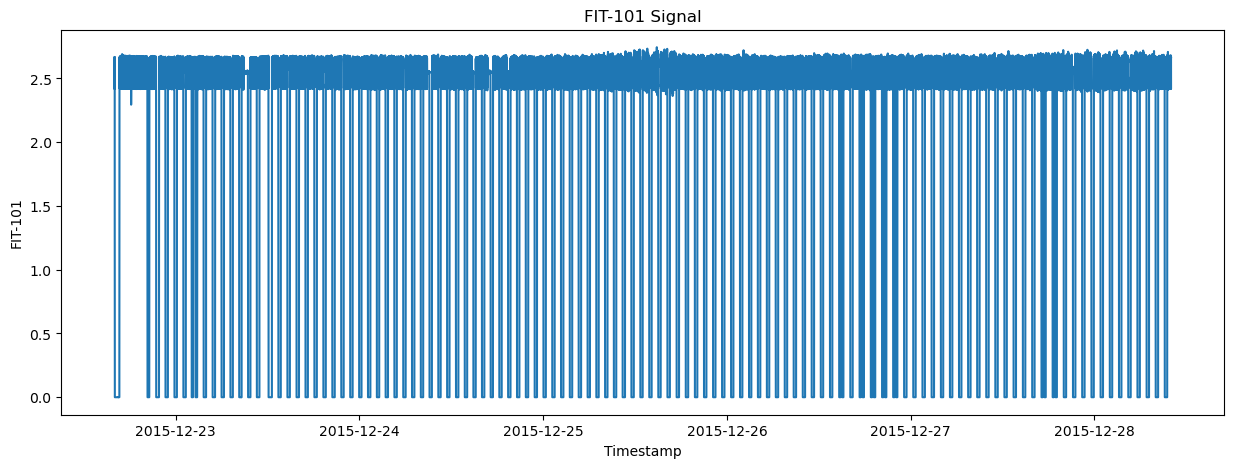

In [11]:
# plot sensor FIT-101
f, ax = plt.subplots(figsize =(15, 5))

fit101 = train_data['FIT101']

plt.plot(train_data['Timestamp'], fit101)
plt.xlabel('Timestamp')
plt.ylabel('FIT-101')
plt.title('FIT-101 Signal')

plt.show()

#### Plot values of actuator P-101

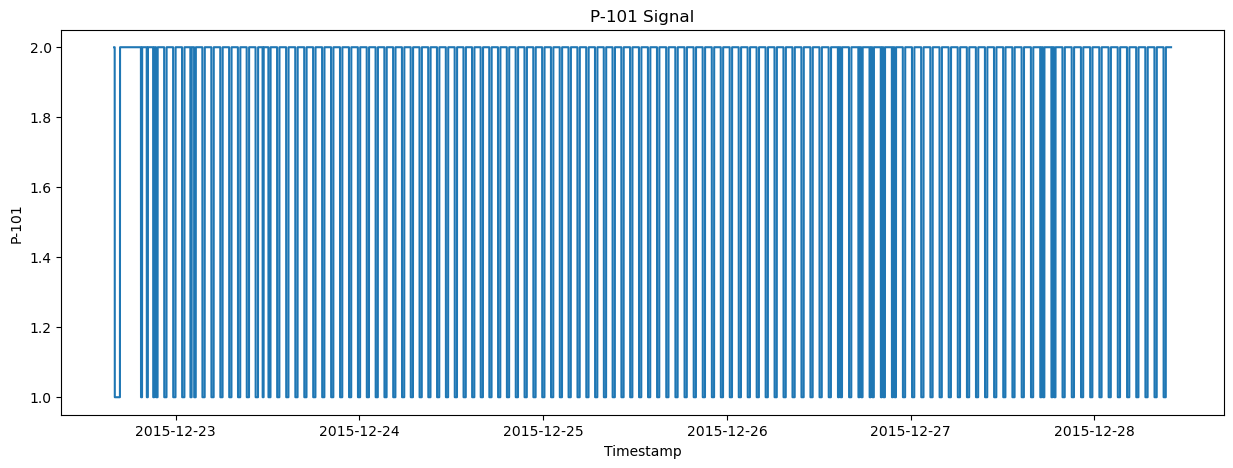

In [12]:
# plot sensor P-101
f, ax = plt.subplots(figsize =(15, 5))

p101 = train_data['P101']

plt.plot(train_data['Timestamp'], p101)
plt.xlabel('Timestamp')
plt.ylabel('P-101')
plt.title('P-101 Signal')

plt.show()

#### Detect Cyclicity

In [13]:
# for better visualization, we will focus on the second 24 hours of the data
start_time = train_data['Timestamp'][0] + pd.DateOffset(days=1)
end_time = start_time + pd.DateOffset(days=1)
print('Start time:', start_time)
print('End time:', end_time)

Start time: 2015-12-23 16:00:00
End time: 2015-12-24 16:00:00


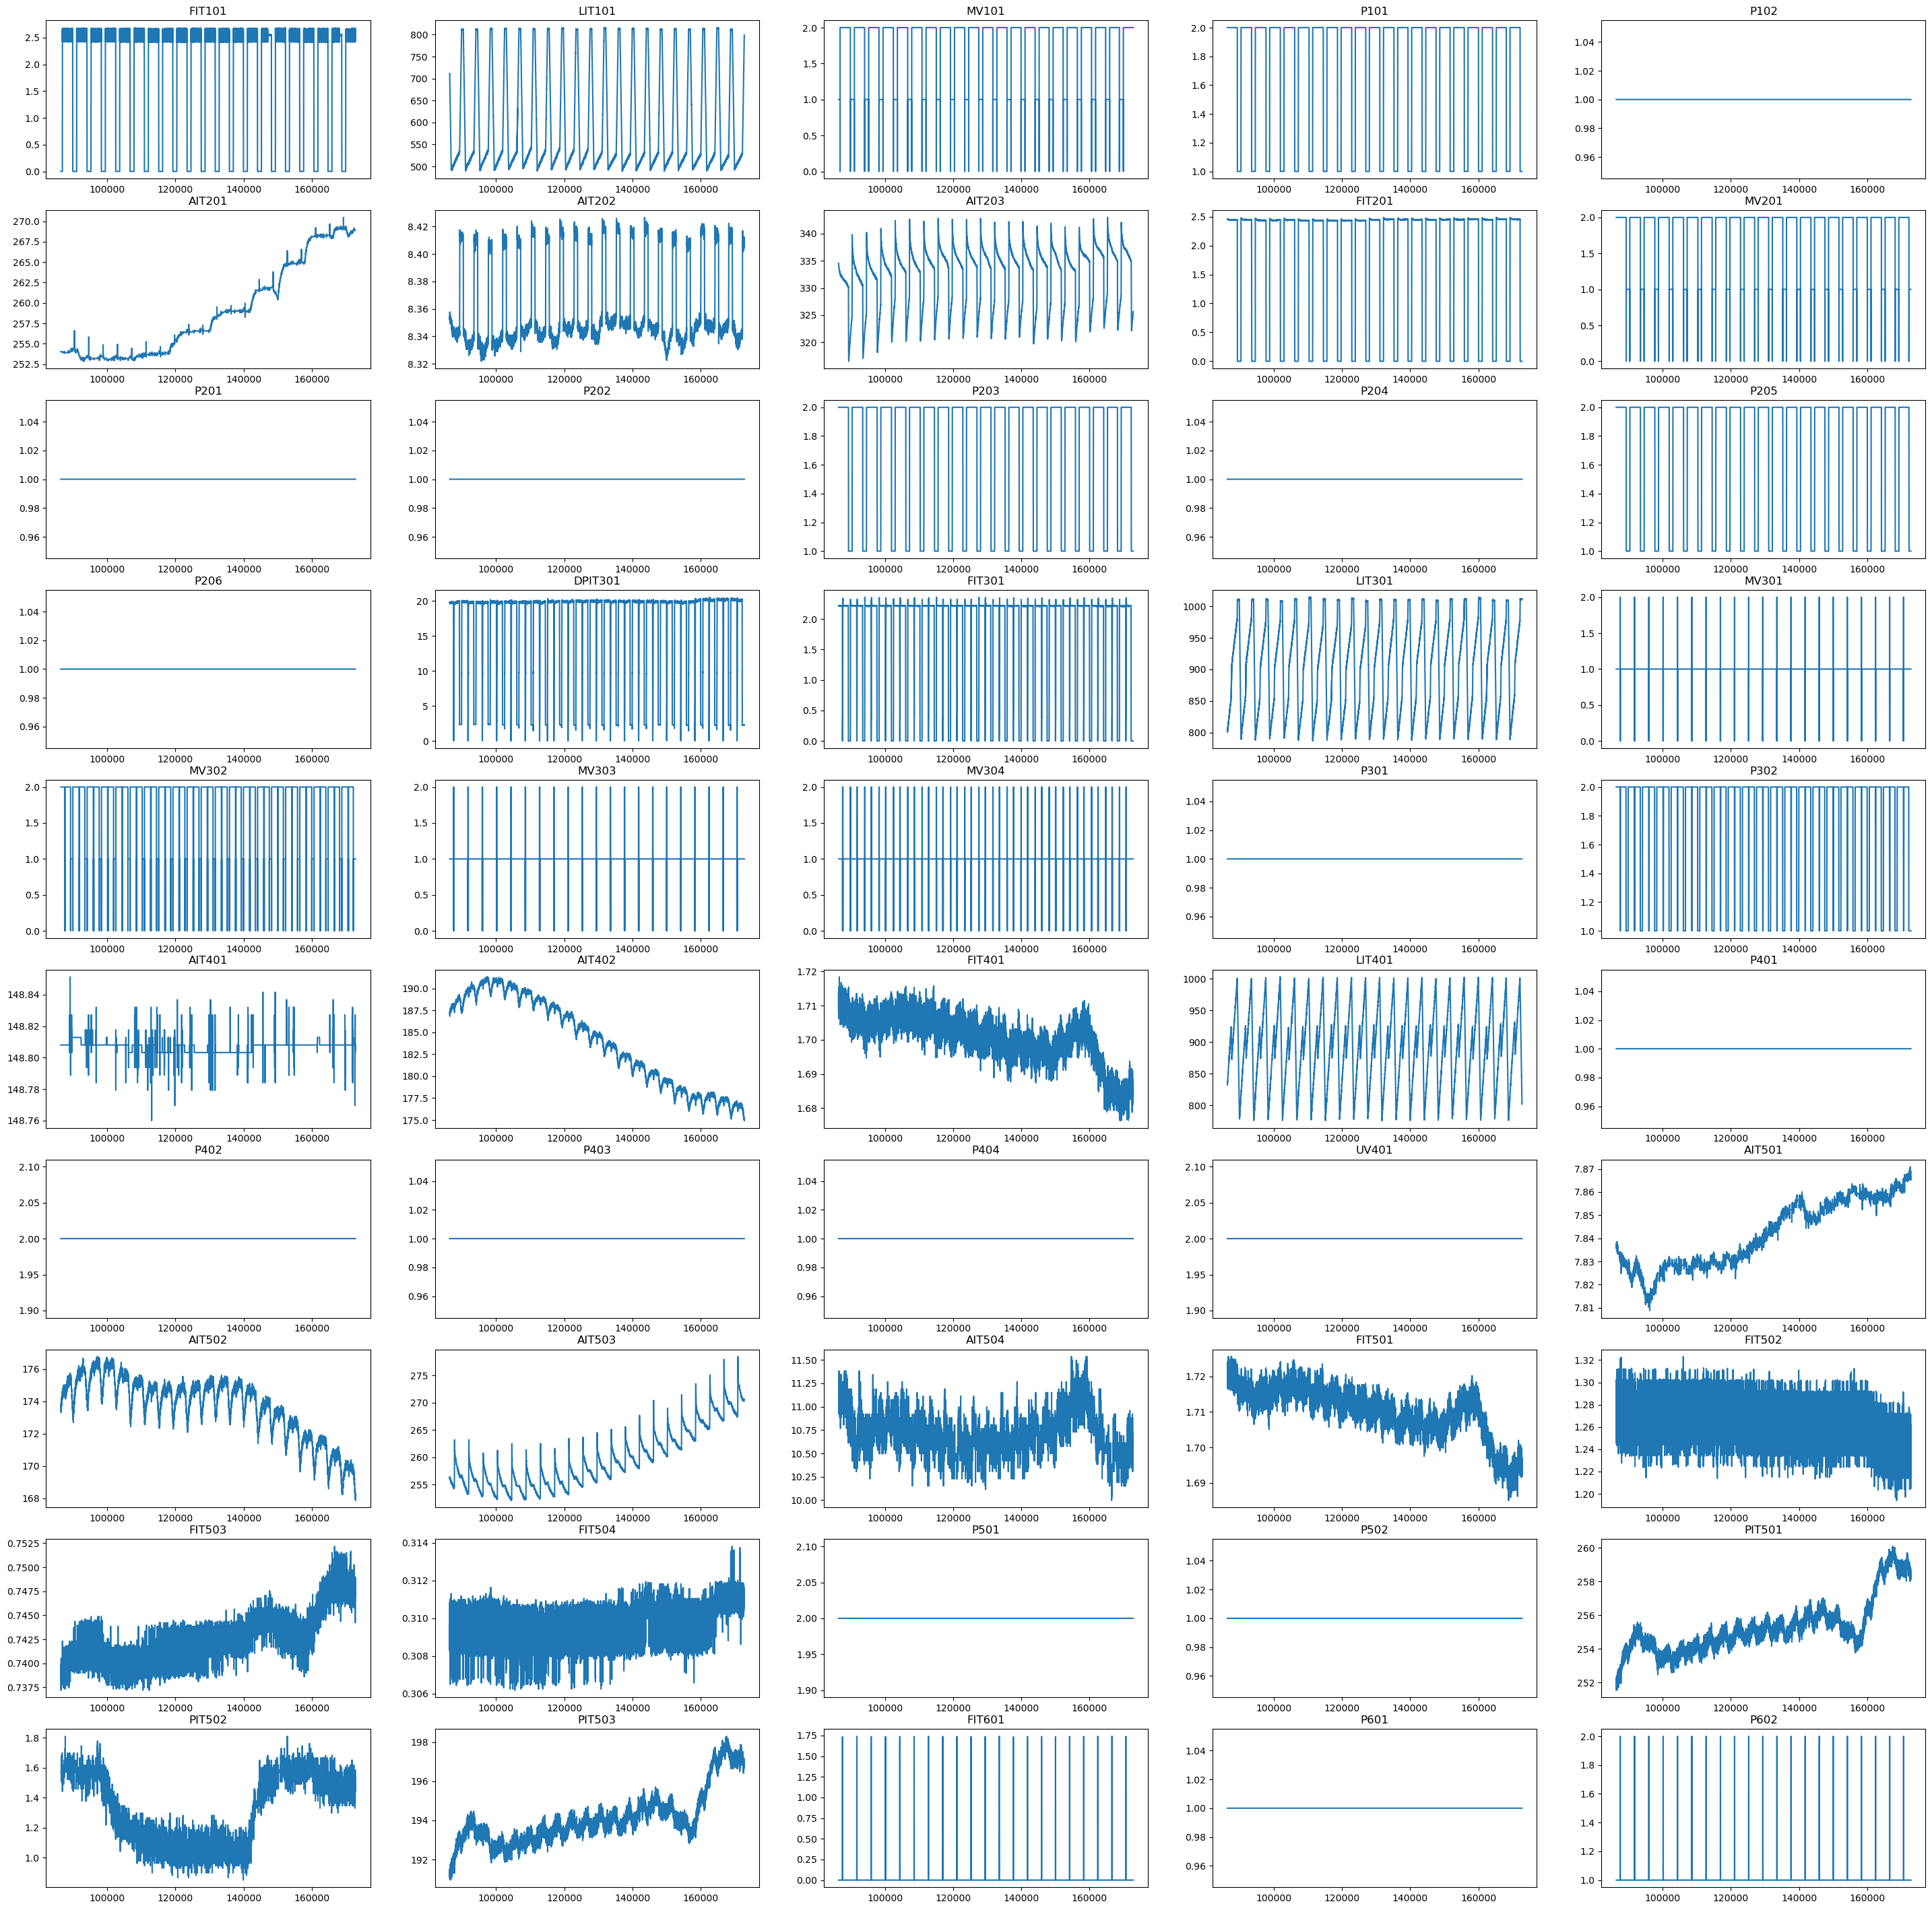

In [14]:
# Plotting scatter matrix
hor_plots = 5
ver_plots = 10
fig, axs = plt.subplots(ver_plots, hor_plots, figsize=(36, 36))
i, j = 0, 0

data_plot = train_data[(train_data['Timestamp'] >= start_time) & (train_data['Timestamp'] < end_time)]

for row in range(ver_plots):
    for col in range(hor_plots):
        feature = signals[j]

        axs[row, col].plot(data_plot[feature])
        axs[row, col].set_title(feature)
        j = j + 1

### 1b. Answers to the three questions

#### Question 1: What types of signals are there?

In [15]:
# find sensors and actuators
# sensors: float values
# actuators: integer values

sensors = []
actuators = []

for signal in signals:
    if train_data[signal].dtype == 'float64':
        sensors.append(signal)
    elif train_data[signal].dtype == 'int64':
        actuators.append(signal)

print('Number of sensors:', len(sensors))
print(sensors)
print('Number of actuators:', len(actuators))
print(actuators)

Number of sensors: 25
['FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601']
Number of actuators: 26
['MV101', 'P101', 'P102', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'P401', 'P402', 'P403', 'P404', 'UV401', 'P501', 'P502', 'P601', 'P602', 'P603']


There are 51 signals in the train dataset. According to the paper introducing the SWaT dataset and the TABOR paper, there are two types of signals, sensors and actuators. **Sensors** convert a physical parameter (i.e. LIT-101 for raw tank water level) to an electronic value. **Actuators** convert a signal into a physical output (i.e. P-101 for pumping water from raw water tank to second stage). There are 25 sensors (float values) and 26 actuators (integer values).

#### Question 2: Are the signals correlated?

Based on our signal correlation heatmap, we detect some strong positive and negative correlations among our data. Positive correlations can be spotted in cases where a signal serves as an input for another or the two signals are actuators that work together for an operation. For instance, actuator P-101, which pumps water from the raw water tank to the second stage showcases extreme positive correlation with sensor FIT-201, the flow transmitter. On the other hand, there are also some extremely negative correlations, mostly between the measurement of an object and signals that act against it. For instance, sensor AIT-504, the RO permeate conductivity analyzer that measures NaCl level, showcases extreme negative correlation with many signals, such as actuator P-501 that pumps dechlorinated water into the RO, thus reducing the levels of NaCl. Overall, we can identify many interesting correlations between the signals.

#### Question 3: Do they show cyclic behavior?

Based on our plots for the 2nd 24 hours of measurements, we can see that many signals show cyclic behavior. For instance, it is easy to validate, even just visually, that signals FIT-101, MV-101, FIT-201, LIT-301 et al., present cycles in this 24-hour window. Also, signals, like AIT-402 and AIT-503, show cyclic behavior, but because we don't have removed trends and seasonality elements from the time series, it is not completely clear. However, overall, most of the signals showcase cyclic behavior.

## 2. LOF task – 1/2 A4 – Individual

### Student
#### Name : Athanasios Georgoutsos
#### ID : 6015883

### 2a. Plot LOF scores

### 2b. Analysis and answers to the questions

## 3. PCA task – 1/2 A4 – Individual

### Student
#### Name : Amar Mesic
#### ID : 5106117

### Imports

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [79]:
# more preprocessing

# Keep columns for signals
signals = train_data.columns.drop(['Id', 'Timestamp', 'Label'])
print('Number of signals:', len(signals))

# Convert timestamp to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], dayfirst=True)

# Extract signal data
train_signals = train_data[signals]

# Standardize the data
scaler = StandardScaler()
train_signals_scaled = scaler.fit_transform(train_signals)

train_signals_scaled.shape, np.var(train_signals_scaled, axis=0).shape

Number of signals: 51


((496800, 51), (51,))

### 3a. Plot PCA residuals

In [81]:
# Fit PCA
n_components = 10
pca = PCA(n_components=n_components)
train_signals_pca = pca.fit_transform(train_signals_scaled)

# Reconstruct the original data from the reduced dimensions
train_signals_reconstructed = pca.inverse_transform(train_signals_pca)

(496800, 51)

In [83]:
train_signals_reconstructed[:, 0].shape

(496800,)

In [100]:
# Define the range of components to test
n_components_list = [2, 3, 5, 10, 20, 30]

# Initialize a dictionary to store the residuals for each number of components
residuals_dict = {}

for n_components in n_components_list:
    # Fit PCA
    pca = PCA(n_components=n_components)
    train_signal_pca = pca.fit_transform(train_signals_scaled)
    
    # Reconstruct the original data from the reduced dimensions
    train_signal_reconstructed = pca.inverse_transform(train_signal_pca)
    
    # Compute reconstruction error (residuals) for the 'P101' signal
    residuals = np.mean((train_signals_scaled[:, 0] - train_signal_reconstructed[:, 0]) ** 2)
    # residuals = np.mean((train_signals_scaled - train_signal_reconstructed) ** 2, axis=1)
    residuals_dict[n_components] = residuals


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


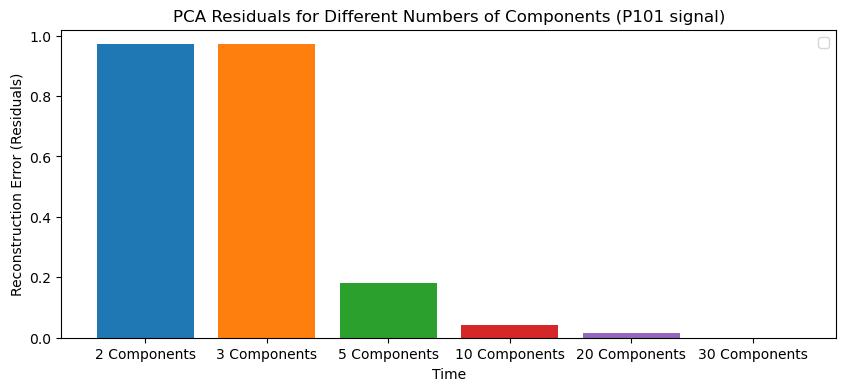

In [101]:
# Plot the residuals for each number of components
plt.figure(figsize=(10, 4))

for n_components, residuals in residuals_dict.items():
    plt.bar(f'{n_components} Components', residuals)

plt.xlabel('Time')
plt.ylabel('Reconstruction Error (Residuals)')
plt.title(f'PCA Residuals for Different Numbers of Components (P101 signal)')
plt.legend()
plt.show()

In [106]:
# Fit PCA
n_components = 30  # You can choose an appropriate number of components
pca = PCA(n_components=n_components)
train_signals_pca = pca.fit_transform(train_signals_scaled)

# Reconstruct the original data from the reduced dimensions
train_signals_reconstructed = pca.inverse_transform(train_signals_pca)

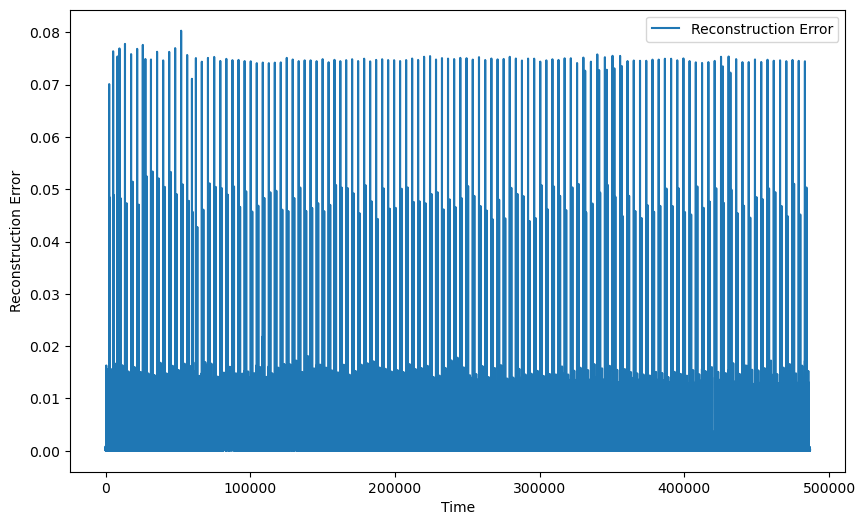

In [107]:
# Compute reconstruction error
# Shed the first 10000 samples which have abnormally high reconstruction error, and make the rest of the data less visible
reconstruction_error = np.mean((train_signals_scaled - train_signals_reconstructed) ** 2, axis=1)[10000:]

# Plot the reconstruction error
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()


### 3b. Analysis and answers to the questions

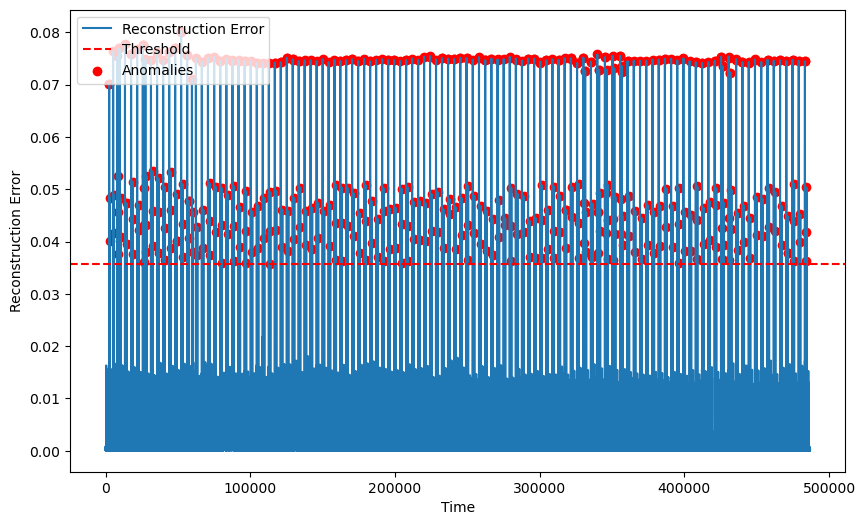

In [108]:
# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 99.9)

# Detect anomalies
anomalies = reconstruction_error > threshold

# Plot the anomalies
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies)[0], reconstruction_error[anomalies], color='red', label='Anomalies')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

### Analysis

We conduct PCA here to detect anomalies using the reconstruction residuals. The chosen reconstruction error function was MSE so that all error values are positive. this makes it easier to visualize the error, as we want all points towards zero.

We did PCA and tested the reconstruction error on the P101 signal for different number of principal components, from 2 to 30. We see a reconstruction error of 1 for 2 and 3 components, with a large steep drop at 5, and slowing down afterwards. Using the elbow method, 5 principal components would be a good choice. We picked 30 as the final count to minimize the residual error and have a manageable amount of abnormalities.

Do we see large abnormalities in the training data? Yes, there is a LOT of abnormalities, almost to the point that the abnormalities appear normal.
Can you explain why these occur? It is hard to say why these abnormalities occur. It could be the simple nature of the data system's water dynamics, that has irregular behaviour every once in a while.

PCA is very good at detecting anomalies that are hidden in a high-dimensional feature space. This is because it tackles outliers in the feature spaces normal to the bases with the highest variances.

## 4. ARMA task – 1/2 A4 - Individual

### Student 
#### Name : Amar Mesic
#### ID : 5106117

In [110]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [109]:
# Extract the 'AIT402' signal
signal_name = 'AIT402'
train_signal = train_data[[signal_name]]

### 4a. Print relevant plots and/or metrics to determine the parameters.

### 4b. Plots to study the detected anomalies

### 4c. Analysis and answers to the questions

The chosen signal to study for the ARMA task was the AIT402 signal. It shows a long-term trend downhill, seeming to be part of a cycle. It also has complex cyclical behavoiur with multiple peaks.

## 5. N-gram task – 1/2 A4 - Individual

### Student
#### Name : Athanasios Georgoutsos
#### ID : 6015883

### 5a. Visualise discretization

### 5b. Analysis and answers to the questions. Also provide relevant plots.

## 6.Comparision task 1 A4 - Individual

### 6a. Use the given guidelines and provide a comparision of the above implemented methods.

## 7. Bonus Task 1 A4

### 7a. Provide implementation and analysis.